## Installing Necessary Libraries

In [1]:
%pip install photutils
%pip install astropy matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Loading and Displaying the raw FITS image

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.background import Background2D, MedianBackground, MMMBackground
import warnings
warnings.filterwarnings('ignore')

fname = "cutout_124.8352_18.5109.fits"
with fits.open(fname) as hdul:
    data = hdul[0].data
    header = hdul[0].header

print("raw shape:", data.shape, "ndim:", data.ndim)

raw shape: (3, 256, 256) ndim: 3


3D data: selecting slice 0 for background estimation


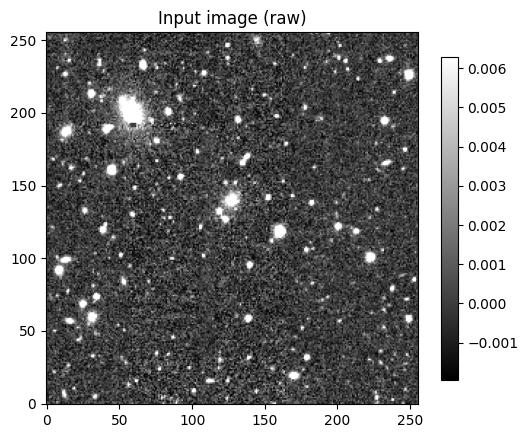

In [3]:
if data.ndim == 3:
    print("3D data: selecting slice 0 for background estimation")
    image = data[0].astype(float)
else:
    image = data.astype(float)

image = np.array(image)
image[np.isinf(image)] = np.nan
mask = np.isnan(image)

plt.figure(figsize=(6,6))
plt.imshow(np.nan_to_num(image), origin='lower', cmap='gray', vmin=np.nanpercentile(image,2), vmax=np.nanpercentile(image,98))
plt.title("Input image (raw)")
plt.colorbar(shrink=0.7)
plt.show()

## Estimating the background

Background2D: background rms (median) = 0.001058946899613097
Background2D: background median = 9.539296260088389e-05


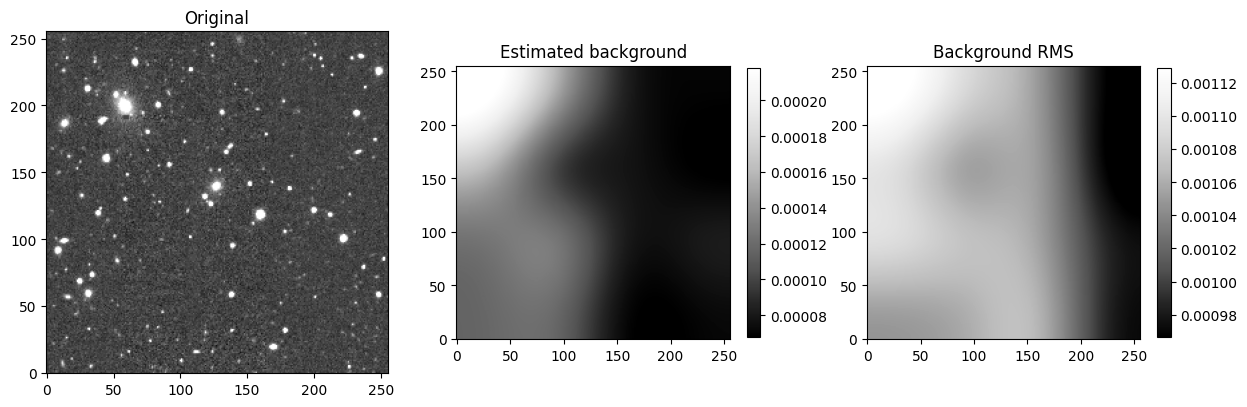

In [4]:
box_size = (64, 64)       
filter_size = (3, 3) 

bkg_estimator = MedianBackground()  
bkg = Background2D(image, box_size, filter_size=filter_size,
                   bkg_estimator=bkg_estimator, mask=mask, exclude_percentile=80)

print("Background2D: background rms (median) =", np.nanmedian(bkg.background_rms))
print("Background2D: background median =", np.nanmedian(bkg.background))

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(image, origin='lower', cmap='gray', vmax=np.nanpercentile(image,99))
ax[0].set_title("Original")
im1 = ax[1].imshow(bkg.background, origin='lower', cmap='Greys_r')
ax[1].set_title("Estimated background")
plt.colorbar(im1, ax=ax[1], shrink=0.7)
im2 = ax[2].imshow(bkg.background_rms, origin='lower', cmap='Greys_r')
ax[2].set_title("Background RMS")
plt.colorbar(im2, ax=ax[2], shrink=0.7)
plt.show()

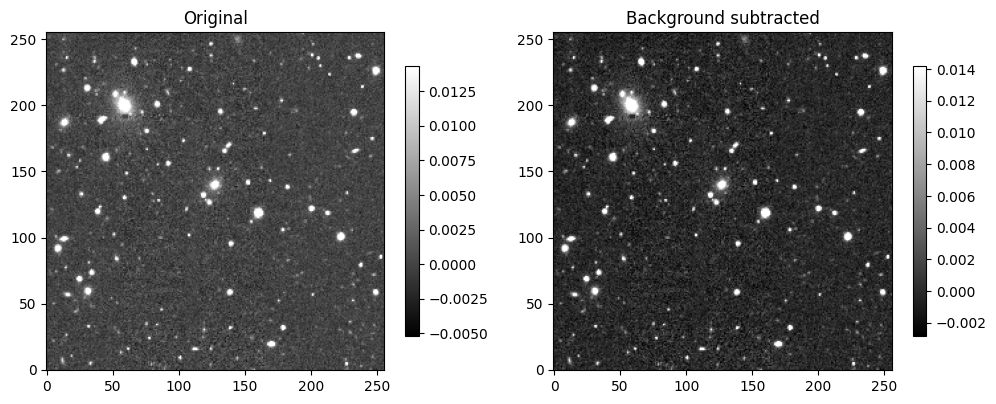

In [5]:
image_sub = image - bkg.background

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(image, origin='lower', cmap='gray', vmax=np.nanpercentile(image,99))
plt.title("Original")
plt.colorbar(shrink=0.7)

plt.subplot(1,2,2)
vmax = np.nanpercentile(image_sub, 99)
plt.imshow(image_sub, origin='lower', cmap='gray', vmin=-vmax*0.2, vmax=vmax)
plt.title("Background subtracted")
plt.colorbar(shrink=0.7)
plt.show()

## SNR map generating

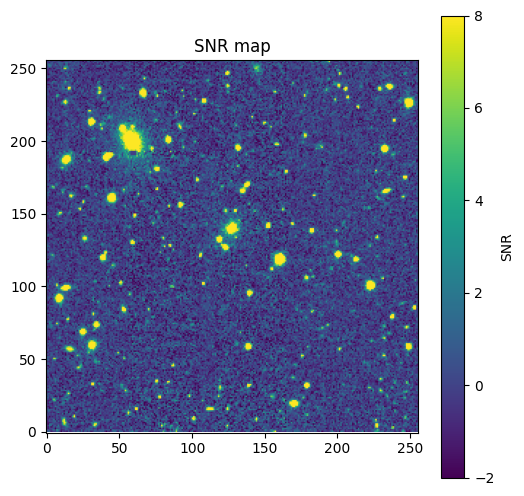

In [6]:
snr = image_sub / (bkg.background_rms + 1e-9)
plt.figure(figsize=(6,6))
plt.imshow(snr, origin='lower', cmap='viridis', vmin=-2, vmax=8)
plt.title("SNR map")
plt.colorbar(label='SNR')
plt.show()

## Identifying Point Sources

In [10]:
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder

mean, median, std = sigma_clipped_stats(image, sigma=3.0)
daofind = DAOStarFinder(fwhm=3.43, threshold=2.0*std, sharplo=0.2, sharphi=1.0, roundlo=-1.0, roundhi=1.0)

sources = daofind(image - median)

snr = sources['peak'] / std
snr_threshold = 5
filtered_sources = sources[snr > snr_threshold]

print(filtered_sources)

 id     xcentroid      ...        mag             daofind_mag    
--- ------------------ ... ------------------ -------------------
  3  80.24585710497286 ...  4.921780367953106 -0.6180441937170825
  6  89.18886330269858 ... 3.5011474672856613 -1.0079392817079076
 14  237.5252615922251 ...  4.024420415620425 -1.1163601186412277
 17 226.56800659439637 ... 1.8768706171630196 -3.3188127180014977
 20  33.15165369841347 ... 2.6605780262514407 -2.1532537714959754
 32 143.90003447857677 ... 3.3704900172989194 -1.5936391757177317
 33 225.82170303903123 ...  3.637278025945379 -1.0480784514060533
 35 100.88232220724754 ... 2.4915720706326066 -2.7220624662818524
 39 18.912090360686303 ... 3.7826508502721277 -1.8327304557121804
 43  178.4439913296686 ...  3.818292775564691 -1.0077883147854956
...                ... ...                ...                 ...
732 169.05855986106175 ...  4.383956638912729  -1.081196928293005
741  67.04391460165166 ... 3.8558814047263903 -1.2982362489817112
752 124.04

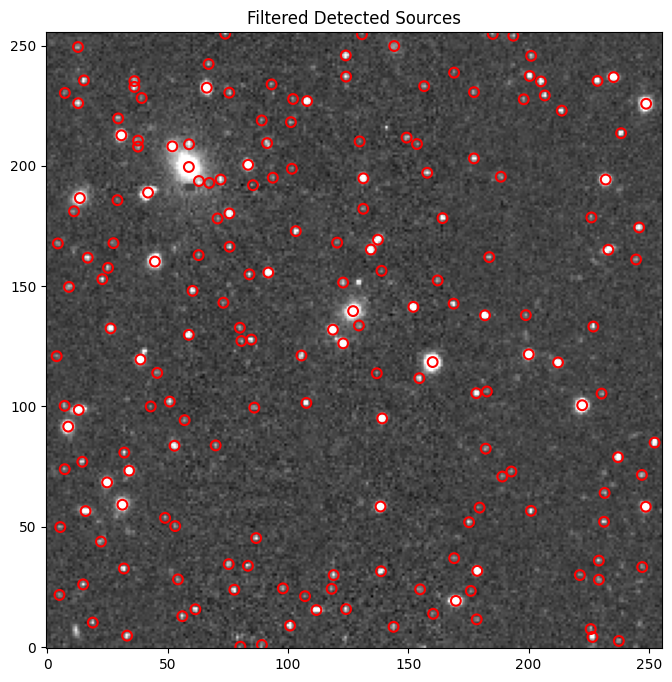

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(image, origin='lower', cmap='gray', vmax=np.nanpercentile(image, 99))
ax.scatter(filtered_sources['xcentroid'], filtered_sources['ycentroid'], s=50, edgecolor='red', facecolor='none', lw=1.5)
ax.set_title("Filtered Detected Sources")
plt.show()